<a href="https://colab.research.google.com/github/Yyzhang2000/AI-Cookbook/blob/main/generative_at_FVSBN_%E2%9C%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.distributions as dist
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
class Binarize:
    def __call__(self, img):
        return (img > 0.5).float()

transform = transforms.Compose([
    transforms.ToTensor(),
    Binarize()
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.59MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.24MB/s]


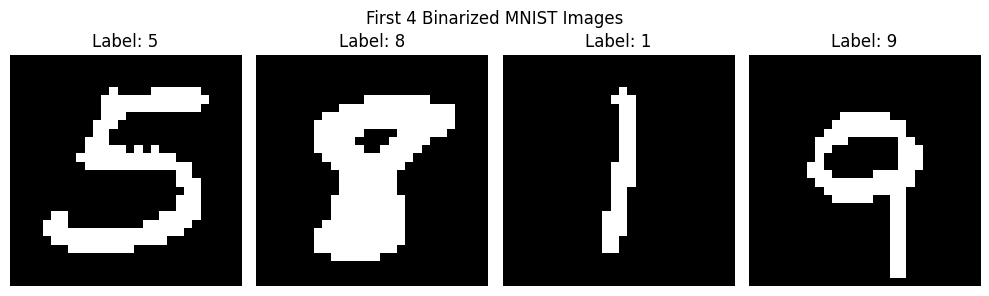

In [3]:
images, labels = next(iter(train_loader))

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(10, 3))
for i in range(4):
    axes[i].imshow(images[i][0], cmap='gray')
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

plt.suptitle("First 4 Binarized MNIST Images")
plt.tight_layout()
plt.show()

In [5]:
class FVSBN(nn.Module):
    def __init__(
            self,
            in_dim: int = 28 * 28
    ):
        super().__init__()

        self.in_dim = in_dim
        self.linear = nn.Linear(in_dim, in_dim, bias = True)

        # Enforce auto-regressive trangular structure
        #  (weights[j][i] = 0 for j >= i)
        for row, weights in enumerate(self.linear.weight.data):
            weights[row:] = 0

    def mean_vector(self, x):
        return torch.sigmoid(self.linear(x))

    def forward(self, x):
        probs = self.mean_vector(x)
        log_probs = x * torch.log(probs + 1e-9) + (1 - x) * torch.log(1 - probs + 1e-9)

        return torch.sum(log_probs, dim = -1)

    def zero_grad_for_extra_weights(self):
        for row, grads in enumerate(self.linear.weight.grad):
            grads[row: ] = 0


    def sample(self, num_samples = 4):
        samples = torch.zeros(num_samples, self.in_dim)
        for n in range(num_samples):
            x = torch.zeros(self.in_dim)
            for i in range(self.in_dim):
                prob = torch.sigmoid(x @ self.linear.weight[i] + self.linear.bias[i])
                x[i] = dist.Bernoulli(prob).sample()

            samples[n] = x

        return samples

In [6]:
model = FVSBN().to(device) # MNIST images are 28x28 = 784
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20
model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        images = images.view(-1, 28*28)  # flatten
        optimizer.zero_grad()

        # Maximize log-likelihood ≡ minimize negative log-likelihood
        neg_log_likelihood = -model(images).mean()
        neg_log_likelihood.backward()

        model.zero_grad_for_extra_weights()  # Enforce triangular weights
        optimizer.step()

        total_loss += neg_log_likelihood.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Loss: 229.1899
Epoch 2, Loss: 150.0371
Epoch 3, Loss: 120.6383
Epoch 4, Loss: 104.7709
Epoch 5, Loss: 95.3392
Epoch 6, Loss: 89.3884
Epoch 7, Loss: 85.4740
Epoch 8, Loss: 82.8184
Epoch 9, Loss: 80.9649
Epoch 10, Loss: 79.6411
Epoch 11, Loss: 78.6649
Epoch 12, Loss: 77.9324
Epoch 13, Loss: 77.3788
Epoch 14, Loss: 76.9382
Epoch 15, Loss: 76.5947
Epoch 16, Loss: 76.3030
Epoch 17, Loss: 76.0735
Epoch 18, Loss: 75.8766
Epoch 19, Loss: 75.7097
Epoch 20, Loss: 75.5718


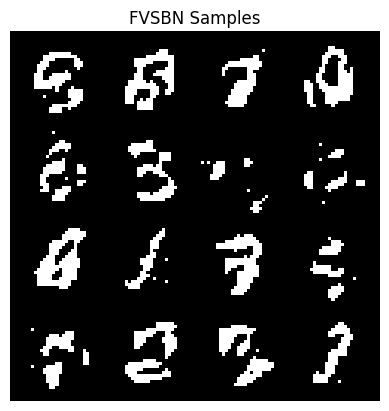

In [8]:
model = model.to('cpu')
model.eval()
with torch.no_grad():
    samples = model.sample(num_samples=16).view(-1, 1, 28, 28)

samples = samples.detach().cpu()
grid = torchvision.utils.make_grid(samples, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.title("FVSBN Samples")
plt.axis("off")
plt.show()

In [9]:
def sample_progress(model, step_points=[0, 100, 400, 784]):
    model.eval()
    sample = torch.zeros(model.in_dim)
    snapshots = {}

    with torch.no_grad():
        for i in range(model.in_dim):
            prob = torch.sigmoid(sample @ model.linear.weight[i] + model.linear.bias[i])
            sample[i] = dist.Bernoulli(prob).sample()

            if (i + 1) in step_points:
                snapshots[i + 1] = sample.clone().view(28, 28)

    return snapshots

def plot_snapshots(snapshots):
    steps = sorted(snapshots.keys())
    fig, axes = plt.subplots(1, len(steps), figsize=(12, 3))
    for idx, step in enumerate(steps):
        axes[idx].imshow(snapshots[step].cpu(), cmap='gray')
        axes[idx].set_title(f"Step {step}")
        axes[idx].axis("off")
    plt.show()

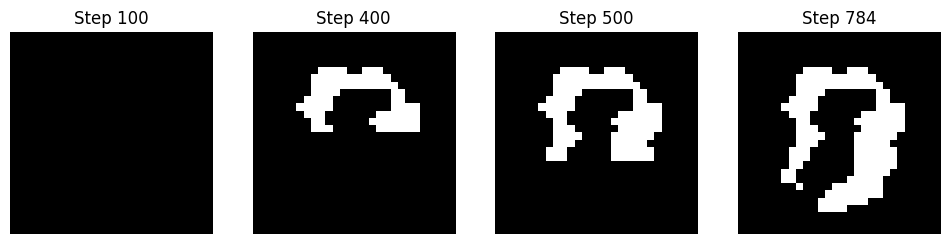

In [11]:
snapshots = sample_progress(model, step_points=[0, 100, 400, 500, 784])
plot_snapshots(snapshots)